In [500]:
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 40)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score

from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


In [501]:
df=pd.read_csv('../processed_data/data_processed.csv')
df['fecha']=pd.to_datetime(df.fecha,format='%Y-%m-%d %H:%M:%S')
df.head(2)

a       b         c     d    e     f   g  h            j         k       l  \
0  4  0.6812  50084.12  50.0  0.0  20.0  AR  1  cat_d26ab52  0.365475  2479.0   
1  4  0.6694  66005.49   0.0  0.0   2.0  AR  1  cat_ea962fb  0.612728  2603.0   

       m  n  p               fecha  monto  score  fraude  Country_AR  \
0  952.0  1  1 2020-03-20 09:28:19  57.63    100       0           1   
1  105.0  1  1 2020-03-09 13:58:28  40.19     25       0           1   

   Country_BR  Country_US  Country_UY  Country_otros  hour_early  
0           0           0           0              0           0  
1           0           0           0              0           0

In [502]:
cantidad = df.set_index('fecha').resample('h').count()
fraude = df.set_index('fecha').resample('h').sum()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cantidad.index, y=cantidad['a'], mode='lines', name='eventos'), secondary_y=False)
fig.add_trace(go.Scatter(x=fraude.index, y=fraude['fraude'], mode='lines', name='fraude'), secondary_y=True)
fig.update_layout(title='Gráfico de Dos Series de Tiempo', xaxis_title='Fecha')
fig.update_yaxes(title_text="a", secondary_y=False)
fig.update_yaxes(title_text="fraude", secondary_y=True)
fig.show()

#### manejo del target

#### Para contestar: ¿Qué pasos puedo seguir para intentar asegurar que la performance del modelo en laboratorio será similar a la de producción?
- Se ha decidio retirar los ultimos registros del dataset, con el fin de realizar validaciones fuera de los datos de entrenamiento. Esto nos permitirá ver el comportamiento real del modelo.
- Dado que se trata de un dataset etiquetado, se procede a realizar un modelo supervisado. Por lo tanto, algunas columnas no serán tenidas en cuenta, como la fecha, 'g' y 'j'.
- respecto a la fecha, el día de la semana no es una variable muy significativa por sí sola. pero la hora si tiene un comportamiento por lo que se dejara solo si es de muy temprano

In [503]:
df.head(2)

a       b         c     d    e     f   g  h            j         k       l  \
0  4  0.6812  50084.12  50.0  0.0  20.0  AR  1  cat_d26ab52  0.365475  2479.0   
1  4  0.6694  66005.49   0.0  0.0   2.0  AR  1  cat_ea962fb  0.612728  2603.0   

       m  n  p               fecha  monto  score  fraude  Country_AR  \
0  952.0  1  1 2020-03-20 09:28:19  57.63    100       0           1   
1  105.0  1  1 2020-03-09 13:58:28  40.19     25       0           1   

   Country_BR  Country_US  Country_UY  Country_otros  hour_early  
0           0           0           0              0           0  
1           0           0           0              0           0

In [504]:
df_validacion=df.sort_values(by='fecha').tail(800)
df=df[~df.index.isin(df_validacion)]
df.drop(columns=['g','j','fecha','p','Country_AR'],inplace=True)

0    0.94978
1    0.05022
Name: fraude, dtype: float64

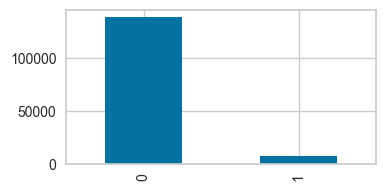

In [505]:
#dado que las clases tienen un furete des-balanceo, se realizara un sobre-muestreo a la clase fraude
df.fraude.value_counts().plot(kind='bar',figsize=(4,2))
df.fraude.value_counts(normalize=True)

In [513]:
#procedemos a realizar un sobre muestreo
X=df.drop(columns='fraude')
y=df.fraude

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#os_us = SMOTETomek(random_state=42)
#X_train, y_train = os_us.fit_resample(X_train, y_train)

fraude
0         0.909096
1         0.090904
dtype: float64

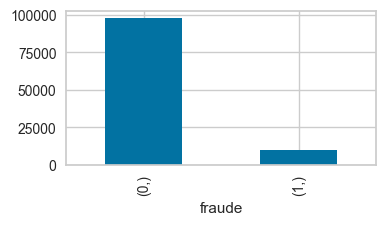

In [520]:
pd.DataFrame(y_train).value_counts().plot(kind='bar',figsize=(4,2))
pd.DataFrame(y_train).value_counts(normalize=True)

In [270]:
len(y_train)

136802

##### Para comenzar, probaremos diferentes modelos con el fin de evaluar el rendimiento de cada uno. para el caso nos apoyaremos en pycaret dada la variedad de modelos y metricas

In [521]:
from pycaret.classification import *
s = setup(pd.concat([X_train,pd.DataFrame(y_train)],axis=1), target = 'fraude', session_id = 123)

In [522]:
best = s.compare_models()

In [523]:
print(best)
model=s.create_model('lightgbm')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [346]:
predict_result = s.predict_model(model)

In [252]:
s.evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

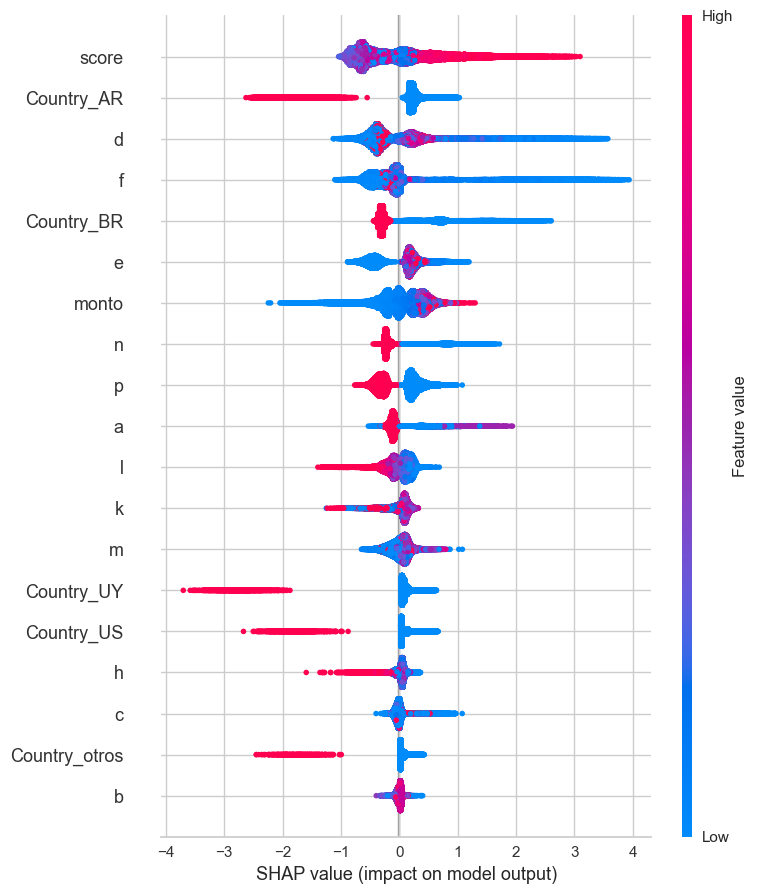

In [ ]:
interpret_model(model, feature='feature_importance')

##### seleccionando mejor modelo

In [420]:
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [299]:
#metricas que usaremos para medir el modelo 
def evaluate_models(y_test, y_pred):    
    print("accuracy =" ,accuracy_score(y_test, y_pred))
    print("precision =" ,precision_score(y_test, y_pred))
    print("recall =" ,recall_score(y_test, y_pred))
    print("f1_score =" ,f1_score(y_test, y_pred))
    print("roc_auc =" ,roc_auc_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

accuracy = 0.9231588971521858
precision = 0.2758878504672897
recall = 0.336986301369863
f1_score = 0.3033915724563206
roc_auc = 0.6453863128741762
[[39977  1937]
 [ 1452   738]]


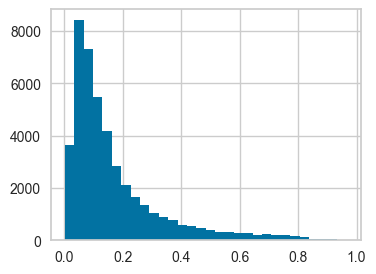

In [383]:
# este al ser el segundo  mejor modelo lo dejamos como comparación
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)
evaluate_models(y_test, y_pred)
plt.figure(figsize=(4, 3)) 
plt.hist(y_prob[:, 1], bins=30);

In [384]:
#realizaremos una validación cruzada para escojer el optimo numero de rondas dle lgbm
param_grid = {
    'num_round': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}
model = lgb.LGBMClassifier()
scoring = 'neg_log_loss'  

# Realiza una búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=3)
grid_search.fit(X_train, y_train)

# Encuentra el valor óptimo de num_round
best_num_round = grid_search.best_params_['num_round']
print(best_num_round)

[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 26057, number of negative: 65144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 91201, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285710 -> initscore=-0.916314
[LightGBM] [Info] Start training from score -0.916314
[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 26057, number of negative: 65144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remo

In [530]:
#entrenamos el modelo
train_data = lgb.Dataset(X_train, label=y_train)
# Definir los hiperparámetros del modelo
params = {
    "objective": "binary","metric": "binary_logloss","boosting_type": "gbdt",
    "num_leaves": 31,"subsample_for_bin":200000,"max_depth":-1,"importance_type":"split",
    "min_child_samples":20, "min_child_weight":0.001,"learning_rate": 0.1,"n_estimators":100,
    "feature_fraction": 0.9,"n_jobs":-1,"boosting_type":'gbdt',"random_state":123,"reg_alpha":0.0
}


# Entrenar el modelo LightGBM, segun la CV las rondas optimas son 900
num_round = 300
bst = lgb.train(params, train_data, num_round)

y_pred_t = bst.predict(X_train)
y_pred = bst.predict(X_test)
#y_pred=model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 9771, number of negative: 97716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 107487, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090904 -> initscore=-2.302646
[LightGBM] [Info] Start training from score -2.302646


In [431]:
'''
# se prueba con un ensamble de gradiente boosting, pero los resultados son similares
params1 = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.1
}

params2 = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05
}

params3 = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 20,
    "learning_rate": 0.2
}

model1 = lgb.train(params1, train_data, num_round)
model2 = lgb.train(params2, train_data, num_round)
model3 = lgb.train(params3, train_data, num_round)

y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

y_pred = (y_pred1 + y_pred2 + y_pred3) / 3
'''

'\n# se prueba con un ensamble de gradiente boosting, pero los resultados son similares\nparams1 = {\n    "objective": "binary",\n    "metric": "binary_logloss",\n    "boosting_type": "gbdt",\n    "num_leaves": 31,\n    "learning_rate": 0.1\n}\n\nparams2 = {\n    "objective": "binary",\n    "metric": "binary_logloss",\n    "boosting_type": "gbdt",\n    "num_leaves": 40,\n    "learning_rate": 0.05\n}\n\nparams3 = {\n    "objective": "binary",\n    "metric": "binary_logloss",\n    "boosting_type": "gbdt",\n    "num_leaves": 20,\n    "learning_rate": 0.2\n}\n\nmodel1 = lgb.train(params1, train_data, num_round)\nmodel2 = lgb.train(params2, train_data, num_round)\nmodel3 = lgb.train(params3, train_data, num_round)\n\ny_pred1 = model1.predict(X_test)\ny_pred2 = model2.predict(X_test)\ny_pred3 = model3.predict(X_test)\n\ny_pred = (y_pred1 + y_pred2 + y_pred3) / 3\n'

accuracy = 0.9531788499909305
precision = 0.6026272577996716
recall = 0.16757990867579908
f1_score = 0.26223651304037154
roc_auc = 0.5809030907600974
[[41672   242]
 [ 1823   367]]


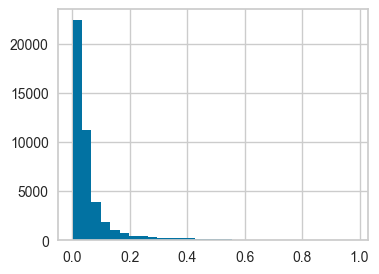

In [531]:
threshold = 0.5
y_pred_binario = (y_pred > threshold).astype(int)
evaluate_models(y_test, y_pred_binario)
plt.figure(figsize=(4, 3)) 
plt.hist(y_pred, bins=30);

In [516]:
threshold = 0.5
y_pred_binario_t = (y_pred_t > threshold).astype(int)
evaluate_models(y_train, y_pred_binario_t)

accuracy = 0.9535757812572683
precision = 0.9501035586518547
recall = 0.5164261590420632
f1_score = 0.6691420236042964
roc_auc = 0.7568571091579385
[[97451   265]
 [ 4725  5046]]


#### tenemos que determinar el punto de corte para contestar la pregunta de maximizar la ganacia, esto nos permite utilizar el modelo en benefico de la empresa

In [27]:
#df['predict']=y_pred = bst.predict(df[X_train.columns])
#df.to_csv('pruebas.csv')

In [533]:
def definir_corte_optimo(y_test, y_prob, costo_fp, costo_fn, beneficio_tp, beneficio_tn):
    corte = np.arange(0, 1, 0.01) 
    
    punto_optimo = None
    max_rentabilidad = -float('inf')
    
    for threshold in corte:
        y_pred = (y_prob >= threshold).astype(int)        
        tp = np.sum((y_test == 1) & (y_pred == 1))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        tn = np.sum((y_test == 0) & (y_pred == 0))
        fn = np.sum((y_test == 1) & (y_pred == 0))        
        rentabilidad = tp * beneficio_tp + tn * beneficio_tn - fp * costo_fp - fn * costo_fn        
        if rentabilidad > max_rentabilidad:
            max_rentabilidad = rentabilidad
            punto_optimo = threshold    
    return punto_optimo, max_rentabilidad

In [534]:
costo_fp = 1.0  # Costo de un falso positivo FP es todo ya que se pierde el ingreso por error del modelo
costo_fn = 1.0  # Costo de un falso negativo FN es todo ya que el modelo no lo pudo detectar
beneficio_tp = 1 # Detectar el fraude y si hay acciones inmediatas generaria la ganancia por ese costo no asumido
beneficio_tn = 0.25  # Detectar los no fraudes correctamente ayuda a generar ese 25% adicional de ganacia
threshold,renta=definir_corte_optimo(y_test, y_pred, costo_fp, costo_fn, beneficio_tp, beneficio_tn)
print(threshold,renta)

0.48 8731.75


In [535]:
#plt.hist(y_pred, bins=30);
tmp=X_test[['monto']]
tmp['fraude']=list(y_test)
tmp['predict']=list(y_pred)
tmp['monto']=tmp.monto*tmp.fraude.apply(lambda x: -1 if x==1 else 1)
tmp=tmp.sort_values(by='predict')
tmp['monto']=tmp['monto'].cumsum()
#tmp.reset_index().monto.plot()

monto = tmp.reset_index()
score = tmp.reset_index()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=monto.index, y=monto['monto'], mode='lines', name='monto'), secondary_y=False)
fig.add_trace(go.Scatter(x=score.index, y=score['predict'], mode='lines', name='predict'), secondary_y=True)

fig.add_shape(
    dict(
        type="line",
        x0=np.max(score[(score.predict>threshold-0.1) & (score.predict<threshold+0.1)].index),
        x1=np.max(score[(score.predict>threshold-0.1) & (score.predict<threshold+.1)].index),
        y0=0,  y1=1,  yref="paper",
        line=dict(color="black", width=2)  
    )
)
fig.update_layout(title='probabilidad de fraude contra ganancia', xaxis_title='acum monto')
fig.show()

In [478]:
threshold = threshold
y_pred_binario = (y_pred > threshold).astype(int)
evaluate_models(y_test, y_pred_binario)

costo_fp = 1.0 
costo_fn = 1.0 
beneficio_tp = 1
beneficio_tn = 0.25 
definir_corte_optimo(y_test, y_pred_binario, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

accuracy = 0.9534282604752403
precision = 0.5971428571428572
recall = 0.1908675799086758
f1_score = 0.2892733564013841
roc_auc = 0.5920697588430148
[[41632   282]
 [ 1772   418]]


(0.01, 8772.0)

#### Probaremos el modelo utilizando el conjunto de datos de validación para evaluar su rendimiento en datos que no se utilizaron durante el entrenamiento. Esto nos proporcionará una breve aproximación de su comportamiento en un entorno de producción

In [396]:
y_predv = bst.predict(df_validacion[X.columns])
threshold = threshold
y_pred_binariov = (y_predv > threshold).astype(int)
evaluate_models(df_validacion.fraude, y_pred_binariov)

costo_fp = 1.0 
costo_fn = 1.0 
beneficio_tp = 1
beneficio_tn = 0.25 
definir_corte_optimo(df_validacion.fraude, y_pred_binariov, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

accuracy = 0.9525
precision = 0.6923076923076923
recall = 0.20930232558139536
f1_score = 0.32142857142857145
roc_auc = 0.6020091548646739
[[753   4]
 [ 34   9]]


(0.01, 159.25)

In [397]:
df_validacion['pred']=y_pred_binariov
df_validacion[['fraude','pred','monto']]

print("total transacciones", df_validacion.monto.sum())
print("transacciones bien clasificadas", df_validacion[(df_validacion.pred==0) & (df_validacion.fraude==0)].monto.sum())
print("fraude evitado", df_validacion[(df_validacion.pred==1) & (df_validacion.fraude==1)].monto.sum())
print("fraude no visto", df_validacion[(df_validacion.pred==0) & (df_validacion.fraude==1)].monto.sum())

total transacciones 32911.49
transacciones bien clasificadas 30025.069999999996
fraude evitado 957.13
fraude no visto 1702.75


42571.0

In [25]:
#y_pred=xgb_classifier.predict_proba(df_validacion[X.columns])
#threshold = 0.55
#y_pred_binario = (y_pred[:, 1] > threshold).astype(int)
#evaluate_models(df_validacion.fraude, y_pred_binario)

#costo_fp = 1.0 
#costo_fn = 1.0 
#beneficio_tp = 0
#beneficio_tn = 0.25 
#definir_corte_optimo(df_validacion.fraude, y_pred_binario, costo_fp, costo_fn, beneficio_tp, beneficio_tn)

accuracy = 0.94125
precision = 0.4411764705882353
recall = 0.3488372093023256
f1_score = 0.38961038961038963
roc_auc = 0.6618690670025499
[[738  19]
 [ 28  15]]


(0.01, 137.5)

## Resumen
### Después de realizar validaciones de modelos de clasificación, se observó que los modelos basados en árboles son especialmente precisos en este tipo de problemas. Además, el equilibrio de las clases demostró ser útil para mejorar el rendimiento del modelo.
- Sobre-muestreo de la clase fraude: Inicialmente, la clase fraude representaba solo un 5% de los casos, pero mediante el sobre-muestreo se logró aumentar su proporción al 23%. No se buscó lograr un equilibrio de 50%-50% entre las clases, ya que se prefirió mantener ese criterio para fines de evaluación.
- Selección del modelo: En la elección del modelo, se optó por el Light Gradient Boosting Machine, que superó por poco al segundo mejor modelo, el XGBoost. Sin embargo, cabe destacar que XGBoost sigue siendo una sólida opción.
- Matriz de costos: Se creó una matriz de costos que permite determinar el punto de corte óptimo para maximizar los beneficios con el modelo, el cual se estableció en 0.55.
- Al revisar contra el dataset de validación el modelo baja su desempeño pero sigue siendo una buena opción para rentabilizar y llevar producción y reentrenar

In [398]:
X

a       b         c     d         e     f   h         k       l  \
0       4  0.6812  50084.12  50.0  0.000000  20.0   1  0.365475  2479.0   
1       4  0.6694  66005.49   0.0  0.000000   2.0   1  0.612728  2603.0   
2       4  0.4718   7059.05   4.0  0.463488  92.0  25  0.651835  2153.0   
3       4  0.7260  10043.10  24.0  0.046845  43.0  43  0.692728  4845.0   
4       4  0.7758  16584.42   2.0  0.154616  54.0   0  0.201354  2856.0   
...    ..     ...       ...   ...       ...   ...  ..       ...     ...   
147008  4  0.2949  22356.33   6.0  0.000000   0.0   3  0.859495  3331.0   
147009  4  0.7728  34031.44   3.0  0.341379  18.0  18  0.685681  2475.0   
147010  4  0.7012  77840.16  34.0  0.179331   3.0  32  0.315430  2497.0   
147011  2  0.7206  31001.65  50.0  0.000000  50.0  31  0.813346  3952.0   
147012  4  0.7727    528.04  50.0  0.120921   6.0   7  0.607441   988.0   

            m  n  monto  score  Country_BR  Country_US  Country_UY  \
0       952.0  1  57.63    100           0           0           0   
1       105.0  1  40.19     25           0           0           0   
2       249.0  1   5.77     23           1           0           0   
3       141.0  1  40.89     23           1           0           0   
4        18.0  1  18.98     71           1           0           0   
...       ... ..    ...    ...         ...         ...         ...   
147008   32.0  1  26.71     62           1           0           0   
147009   39.0  1   5.47     37           1           0           0   
147010  219.0  1   6.28     57           1           0           0   
147011   84.0  1  40.52      0           0           0           1   
147012  349.0  1  46.76     72           1           0           0   

        Country_otros  hour_early  
0                   0           0  
1                   0           0  
2                   0           0  
3                   0           0  
4                   0           0  
...               ...         ...  
147008              0           0  
147009              0           0  
147010              0           0  
147011              0           0  
147012              0           0  

[147013 rows x 18 columns]

In [ ]:
#### como ejercicio adicional intentaremos con una red nuronal

In [401]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [405]:
#con una simple red neuronal los resultados no son nada alentadores 
model = keras.Sequential([
    layers.Input(shape=(18,)),  
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

Epoch 1/10
2138/2138 [==============================] - 7s 3ms/step - loss: 1064.2778 - accuracy: 0.6745 - val_loss: 0.3868 - val_accuracy: 0.9503
Epoch 2/10
2138/2138 [==============================] - 6s 3ms/step - loss: 7.9245 - accuracy: 0.7132 - val_loss: 0.3822 - val_accuracy: 0.9503
Epoch 3/10
2138/2138 [==============================] - 5s 3ms/step - loss: 1.1647 - accuracy: 0.7140 - val_loss: 0.3873 - val_accuracy: 0.9503
Epoch 4/10
2138/2138 [==============================] - 5s 3ms/step - loss: 0.8673 - accuracy: 0.7143 - val_loss: 0.3785 - val_accuracy: 0.9503
Epoch 5/10
2138/2138 [==============================] - 5s 3ms/step - loss: 1.1248 - accuracy: 0.7143 - val_loss: 0.3804 - val_accuracy: 0.9503
Epoch 6/10
2138/2138 [==============================] - 5s 3ms/step - loss: 0.6303 - accuracy: 0.7144 - val_loss: 0.3833 - val_accuracy: 0.9504
Epoch 7/10
2138/2138 [==============================] - 6s 3ms/step - loss: 0.6515 - accuracy: 0.7146 - val_loss: 0.3835 - val_accura

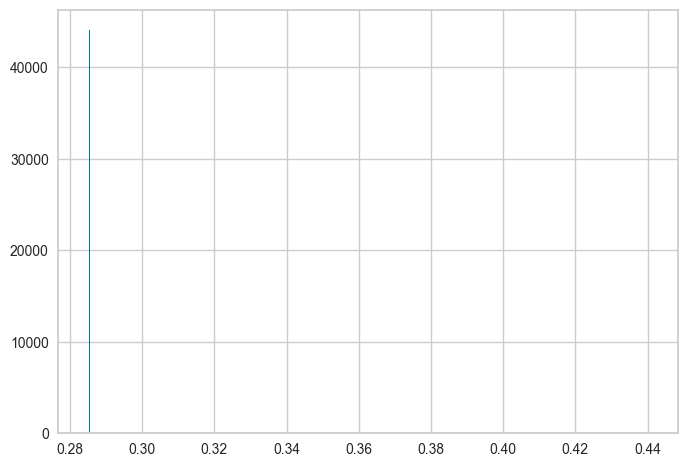

In [412]:
plt.hist(y_pred,bins=300);

In [406]:
threshold = 0.5
y_pred_binario = (y_pred > threshold).astype(int)
evaluate_models(y_test, y_pred_binario)

accuracy = 0.9503446399419554
precision = 0.0
recall = 0.0
f1_score = 0.0
roc_auc = 0.5
[[41914     0]
 [ 2190     0]]
